In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [14]:
# get the name split line
words = open('names.txt', 'r').read().splitlines()
# words[:8]

In [15]:
# len(words)

In [16]:

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
# print(itos)

In [17]:
# dataset

block_size = 3 # context length: no of character to predict the next one?
X, Y = [], []
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
#         print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [18]:
# print(X[:13])
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [19]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words: # words are name strings

        #  print(w)
        context = [0] * block_size # initial [0,0,0] contenxt
        for ch in w + '.': # if w is emma then emma.
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
#     print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [25]:
C = torch.randn((27, 2)) # dimension of the latent space--> for vec2word
print(C)

tensor([[ 4.4858e-01,  7.9647e-01],
        [-9.7409e-01,  2.2888e+00],
        [ 2.2304e-01,  1.9323e+00],
        [-5.3963e-02, -1.2077e+00],
        [-7.0310e-01, -1.8253e+00],
        [-9.6312e-02,  1.0983e+00],
        [ 6.5338e-01,  5.5442e-01],
        [ 6.7032e-01,  5.3407e-01],
        [-4.1282e-01,  1.6155e-01],
        [-4.2798e-01, -4.1688e-01],
        [-4.7918e-01, -7.4238e-01],
        [ 1.3047e+00,  1.2665e+00],
        [ 6.8565e-01,  4.2108e-01],
        [-8.3434e-01, -6.1461e-02],
        [ 3.6654e-01, -4.1296e-03],
        [-8.3920e-02, -2.0808e+00],
        [ 6.2002e-01,  3.7503e-01],
        [ 1.3063e+00, -2.5737e-01],
        [ 1.1180e-03, -8.8148e-01],
        [ 7.0782e-01,  5.3092e-01],
        [-5.9268e-01, -1.0547e+00],
        [-4.1120e-01,  7.9229e-01],
        [-6.0798e-01, -6.5717e-01],
        [-7.8876e-01,  7.0598e-01],
        [ 2.2851e+00, -1.0605e+00],
        [ 8.9932e-01,  3.7839e-01],
        [ 2.0881e-01,  1.4498e+00]])


In [28]:
emb = C[X] # X@C---->  
# check in the video -->
# otuput of the c---> embedding 
### ...

k=torch.tensor([[0,0,0]])
# print(k@C)
print(k.shape)
print(C.shape)
print(C[k])
# meb=C[k]
# meb.shape
emb.shape

torch.Size([1, 3])
torch.Size([27, 2])
tensor([[[0.4486, 0.7965],
         [0.4486, 0.7965],
         [0.4486, 0.7965]]])


torch.Size([228146, 3, 2])

In [85]:
#  no_of_neuraon is 1000 that is why bias is also 100
W1 = torch.randn((6, 100)) # understood why 6 feature, w1 is the output of the C layer--> flatten step
b1 = torch.randn(100)

In [86]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # it arranges itself emb view 
print(h.shape)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

torch.Size([228146, 100])


In [87]:
logits = h @ W2 + b2
print(f"logits {logits.shape}")
counts = logits.exp()

logits torch.Size([228146, 27])


In [88]:
prob = counts / counts.sum(1, keepdims=True)

In [89]:
# prob.shape

In [90]:
# Xtr.shape, Ytr.shape # dataset

In [91]:
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [92]:
# sum(p.nelement() for p in parameters) # number of parameters in total

In [93]:
for p in parameters:
    p.requires_grad = True

In [94]:
lre = torch.linspace(-3, 0, 1000) ## learning rate optimal search
lrs = 10**lre

In [95]:
lri = []
lossi = []
stepi = []

In [96]:
for i in range(200):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # 0 se 2 lakh se koi se bhi 32
  
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) ## softmax and loss output
    #print(loss.item()) 
  
    # backward pass
    for p in parameters:
        p.grad = None #
    loss.backward() #-----> custom made
  
    # update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad # changes one time only

    # track stats
    #lri.append(lre[i])
    stepi.append(i) # which interation going back 
    lossi.append(loss.log10().item()) ## do it for good representaiton of plot

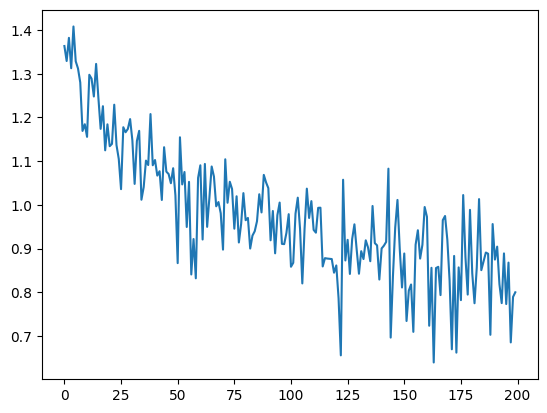

In [97]:
plt.plot(stepi, lossi)

In [99]:
emb = C[Xtr] # (32, 3, 2)
print(emb.shape) # not 2 lakh because 
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

torch.Size([182625, 3, 10])


tensor(6.9192, grad_fn=<NllLossBackward0>)

In [101]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(6.8567, grad_fn=<NllLossBackward0>)

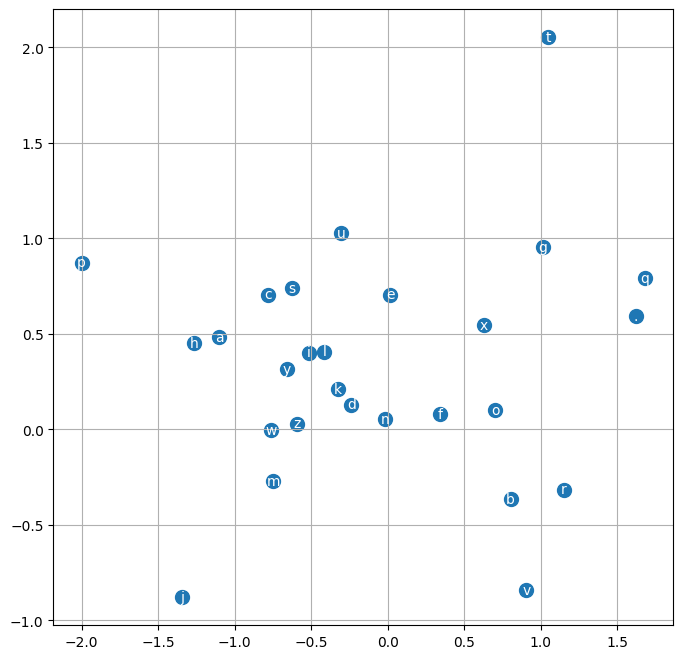

In [102]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=100) # s size of gole
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [103]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [105]:
# how to generate name from the model;
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20): 
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1) ## exponential sum across y axis
#         print(probs.shape)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

mora.
miya.
luzaria.
hhhiioie.
mad.
ehoadd.
coynioaidlayagei.
parseysha.
aotoa.
lalyikonnoeage.
sadd.
riviiaynangtd.
riviya.
xayradiioie.
gadee.
juqhoramarian.
miernn.
mieryn.
alierynhrnrilynoulinjeqya.
syia.
